# Brain Tumor Classification - Stage Prediction

**Objective:** Build a machine learning model to classify brain tumor cancer stages (1-4) based on clinical and imaging features.

**Evaluation Metric:** F1 Score

---

## 1. Import Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Load Data

In [98]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nFirst few rows of training data:")
train_df.head()

Training data shape: (7000, 20)
Test data shape: (3000, 19)

First few rows of training data:


,tumor_type,size,location,edema,necrosis,enhancement,shape,margins,calcification,cystic_components,hemorrhage,ki67_index,mitotic_count,age,gender,symptoms_duration,neurological_deficit,kps_score,cancer_stage,id
0,pituitary,khlat_3lik,frontal,1,0,none,irregular,poorly_defined,1,0,0,100.0,19,65,female,233,0,90,IV,0
1,glioma,normal_brk,frontal,0,0,none,irregular,well_defined,0,1,0,40.0,13,84,amira,233,1,60,IV,1
2,metastatic,normal_brk,occipital,1,0,mild,irregular,well_defined,1,0,0,95.0,2,79,wa7ch,19,1,60,IV,2
3,meningioma,normal_brk,frontal,1,1,none,irregular,poorly_defined,1,0,0,100.0,13,71,wa7ch,157,0,80,IV,3
4,meningioma,normal_brk,brainstem,0,1,ring,irregular,well_defined,0,0,0,25.0,18,31,amira,207,1,90,IV,4


## 3. Exploratory Data Analysis (EDA)

In [99]:
# Basic info
print("Dataset Info:")
print(train_df.info())
print("\n" + "="*50)
print("\nDataset Description:")
print(train_df.describe())
print("\n" + "="*50)
print("\nMissing Values:")
print(train_df.isnull().sum())
print("\n" + "="*50)
print("\nTarget Variable (Cancer Stage) Distribution:")
print(train_df['cancer_stage'].value_counts())
print("\nTumor Type Distribution:")
print(train_df['tumor_type'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tumor_type            7000 non-null   object 
 1   size                  7000 non-null   object 
 2   location              7000 non-null   object 
 3   edema                 7000 non-null   int64  
 4   necrosis              7000 non-null   int64  
 5   enhancement           7000 non-null   object 
 6   shape                 7000 non-null   object 
 7   margins               7000 non-null   object 
 8   calcification         7000 non-null   int64  
 9   cystic_components     7000 non-null   int64  
 10  hemorrhage            7000 non-null   int64  
 11  ki67_index            7000 non-null   float64
 12  mitotic_count         7000 non-null   int64  
 13  age                   7000 non-null   int64  
 14  gender                7000 non-null   object 
 15  symptom

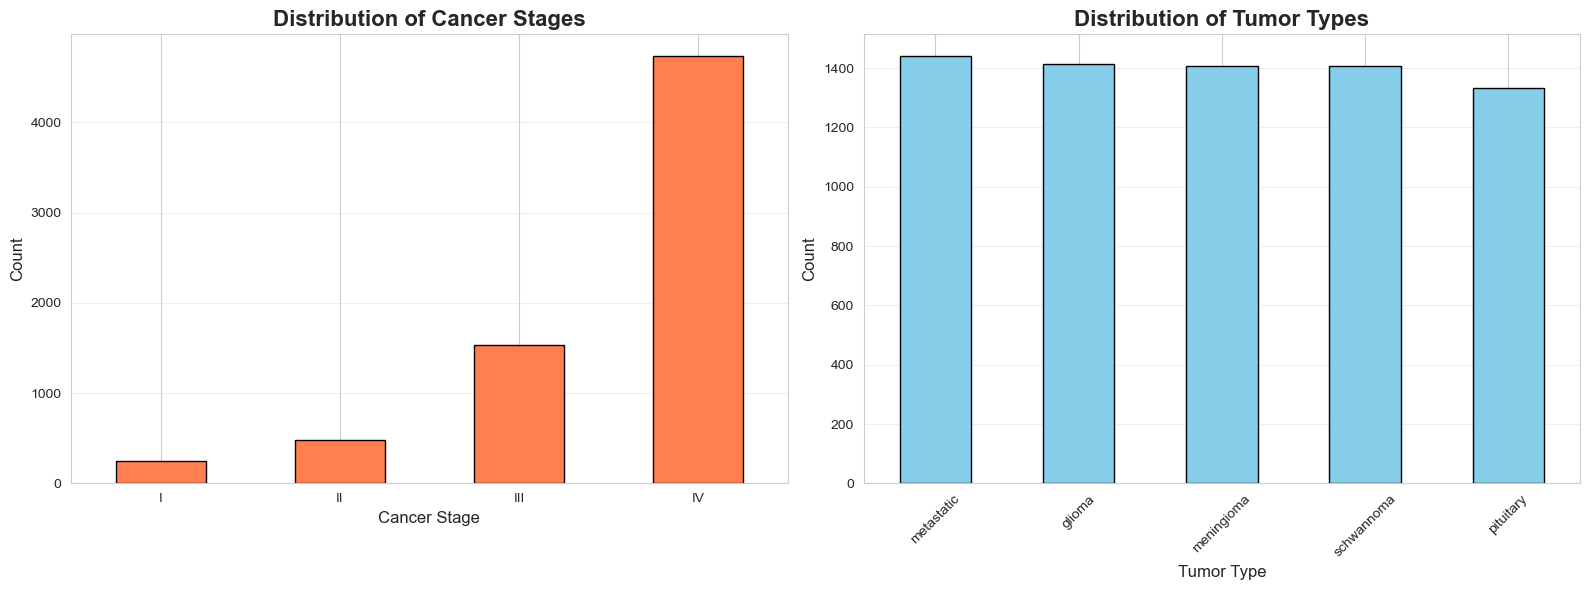

In [100]:
# Visualize cancer stage distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cancer Stage Distribution
train_df['cancer_stage'].value_counts().sort_index().plot(kind='bar', color='coral', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Cancer Stages', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Cancer Stage', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Tumor Type Distribution
train_df['tumor_type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Tumor Types', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Tumor Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

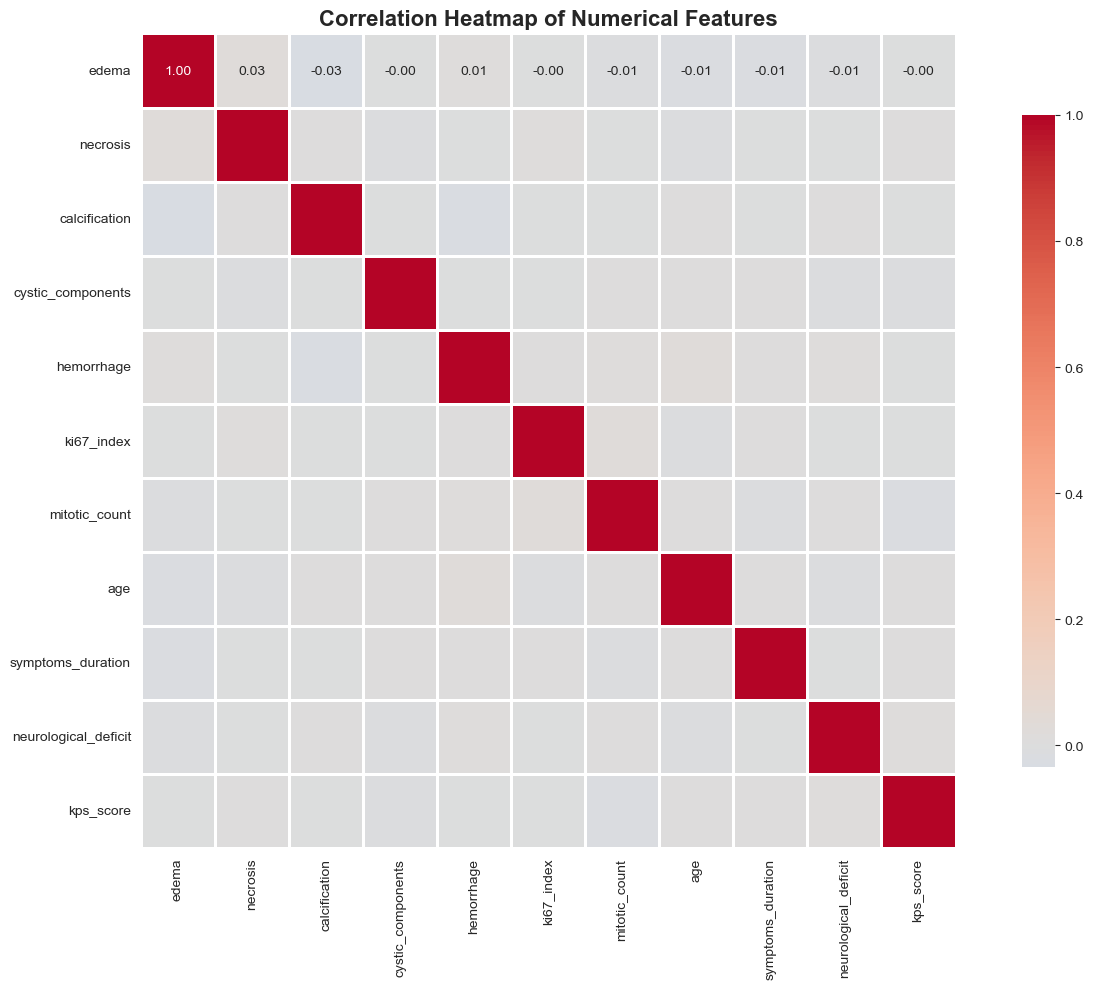

In [101]:
# Correlation heatmap for numerical features
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')

plt.figure(figsize=(14, 10))
correlation_matrix = train_df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

## 3.5 Feature Engineering - Create New Features

Feature engineering can significantly boost model performance by creating more informative features.

In [102]:
# Feature Engineering - Add new features that might be predictive
def add_engineered_features(df):
    """Create new features based on domain knowledge and feature interactions"""
    df = df.copy()
    
    # 1. Aggressiveness Score (ki67 and mitotic count indicate tumor aggressiveness)
    df['aggressiveness_score'] = df['ki67_index'] * 0.5 + df['mitotic_count'] * 2.5
    
    # 2. Risk Score (combine multiple risk factors)
    df['risk_score'] = (
        df['necrosis'] * 20 +
        df['hemorrhage'] * 15 + 
        df['edema'] * 10 +
        df['cystic_components'] * 5
    )
    
    # 3. Age groups (cancer stages can correlate with age) - encoded as numbers
    df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 100], labels=[0, 1, 2, 3])
    df['age_group'] = df['age_group'].astype(int)
    
    # 4. Ki67 categories (clinical thresholds) - encoded as numbers
    df['ki67_category'] = pd.cut(df['ki67_index'], 
                                   bins=[-1, 5, 15, 30, 100], 
                                   labels=[0, 1, 2, 3])
    df['ki67_category'] = df['ki67_category'].astype(int)
    
    # 5. Mitotic rate category - encoded as numbers
    df['mitotic_category'] = pd.cut(df['mitotic_count'], 
                                      bins=[-1, 5, 10, 15, 25], 
                                      labels=[0, 1, 2, 3])
    df['mitotic_category'] = df['mitotic_category'].astype(int)
    
    # 6. Symptoms severity (longer duration + neurological deficit)
    df['symptoms_severity'] = df['symptoms_duration'] + (df['neurological_deficit'] * 100)
    
    # 7. Performance status category - encoded as numbers
    df['kps_category'] = pd.cut(df['kps_score'], 
                                  bins=[0, 50, 70, 90, 100], 
                                  labels=[0, 1, 2, 3])
    df['kps_category'] = df['kps_category'].astype(int)
    
    # 8. Tumor complexity (combination of features)
    df['tumor_complexity'] = (
        df['calcification'] + 
        df['cystic_components'] + 
        df['hemorrhage'] + 
        df['necrosis']
    )
    
    # 9. Interaction: ki67 * mitotic count
    df['ki67_mitotic_interaction'] = df['ki67_index'] * df['mitotic_count']
    
    # 10. Age * ki67 interaction
    df['age_ki67_interaction'] = df['age'] * df['ki67_index']
    
    return df

# Apply feature engineering to train and test sets
print("Adding engineered features to training data...")
train_df_engineered = add_engineered_features(train_df)
print("Adding engineered features to test data...")
test_df_engineered = add_engineered_features(test_df)

print(f"\nOriginal features: {train_df.shape[1]}")
print(f"With engineered features: {train_df_engineered.shape[1]}")
print(f"New features added: {train_df_engineered.shape[1] - train_df.shape[1]}")

# Show new features
new_features = [col for col in train_df_engineered.columns if col not in train_df.columns]
print(f"\nNew features created: {new_features}")

Adding engineered features to training data...
Adding engineered features to test data...

Original features: 20
With engineered features: 30
New features added: 10

New features created: ['aggressiveness_score', 'risk_score', 'age_group', 'ki67_category', 'mitotic_category', 'symptoms_severity', 'kps_category', 'tumor_complexity', 'ki67_mitotic_interaction', 'age_ki67_interaction']


In [103]:
# Update the dataframes to use engineered versions
train_df = train_df_engineered
test_df = test_df_engineered

print("✓ Training and test data updated with engineered features")

✓ Training and test data updated with engineered features


In [104]:
# Separate features and target
X = train_df.drop(['cancer_stage', 'id'], axis=1)
y = train_df['cancer_stage']
test_ids = test_df['id']
X_test = test_df.drop(['id'], axis=1)

# Encode target variable for models that require numerical labels
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nOriginal target classes: {target_encoder.classes_}")
print(f"Encoded as: {np.unique(y_encoded)}")
print(f"\nTarget variable distribution:")
print(pd.Series(y).value_counts().sort_index())
print(f"\nCategorical columns to encode:")
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

Features shape: (7000, 28)
Target shape: (7000,)

Original target classes: ['I' 'II' 'III' 'IV']
Encoded as: [0 1 2 3]

Target variable distribution:
cancer_stage
I       250
II      481
III    1534
IV     4735
Name: count, dtype: int64

Categorical columns to encode:
['tumor_type', 'size', 'location', 'enhancement', 'shape', 'margins', 'gender']


In [105]:
# Encode categorical variables
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print("\nEncoding complete!")

Encoded tumor_type: 5 unique values
Encoded size: 5 unique values
Encoded location: 6 unique values
Encoded enhancement: 5 unique values
Encoded shape: 2 unique values
Encoded margins: 2 unique values
Encoded gender: 4 unique values

Encoding complete!


In [106]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 5600
Validation set size: 1400
Test set size: 3000


## 5. Model Training

In [107]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

# Evaluation
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"\nRandom Forest Results:")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Training Random Forest Classifier...

Random Forest Results:
Training F1 Score: 1.0000
Validation F1 Score: 0.7384

Random Forest Results:
Training F1 Score: 1.0000
Validation F1 Score: 0.7384


In [108]:
# Classification Report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val, target_names=target_encoder.classes_))


Classification Report (Validation Set):
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        50
          II       0.72      0.14      0.23        96
         III       0.61      0.56      0.59       307
          IV       0.82      0.95      0.88       947

    accuracy                           0.78      1400
   macro avg       0.54      0.41      0.42      1400
weighted avg       0.74      0.78      0.74      1400



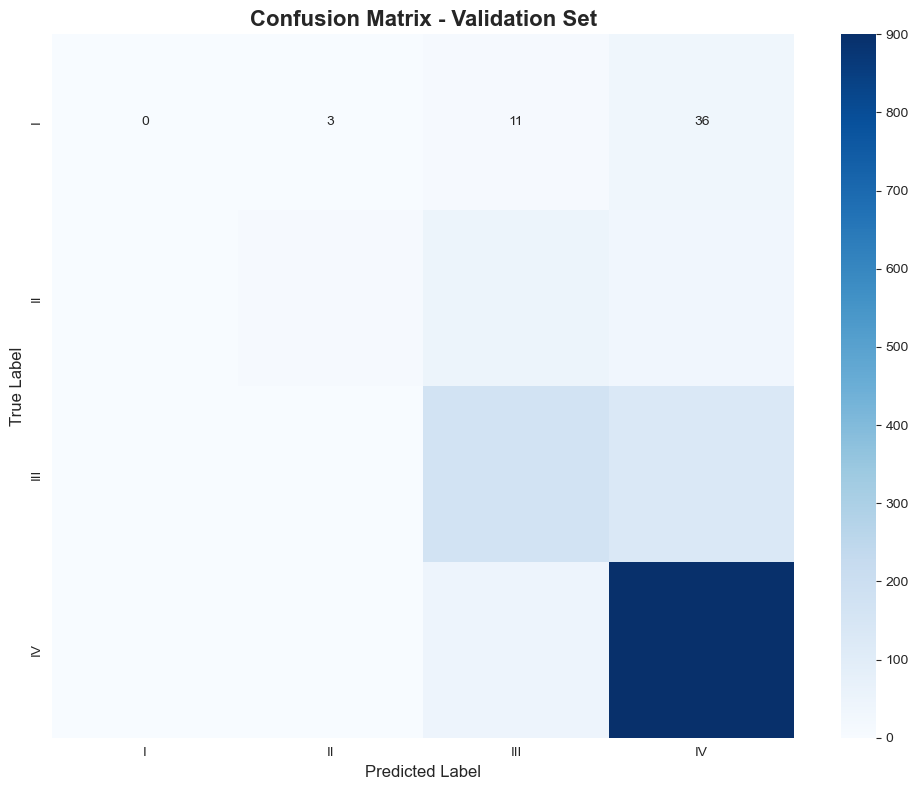

In [109]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

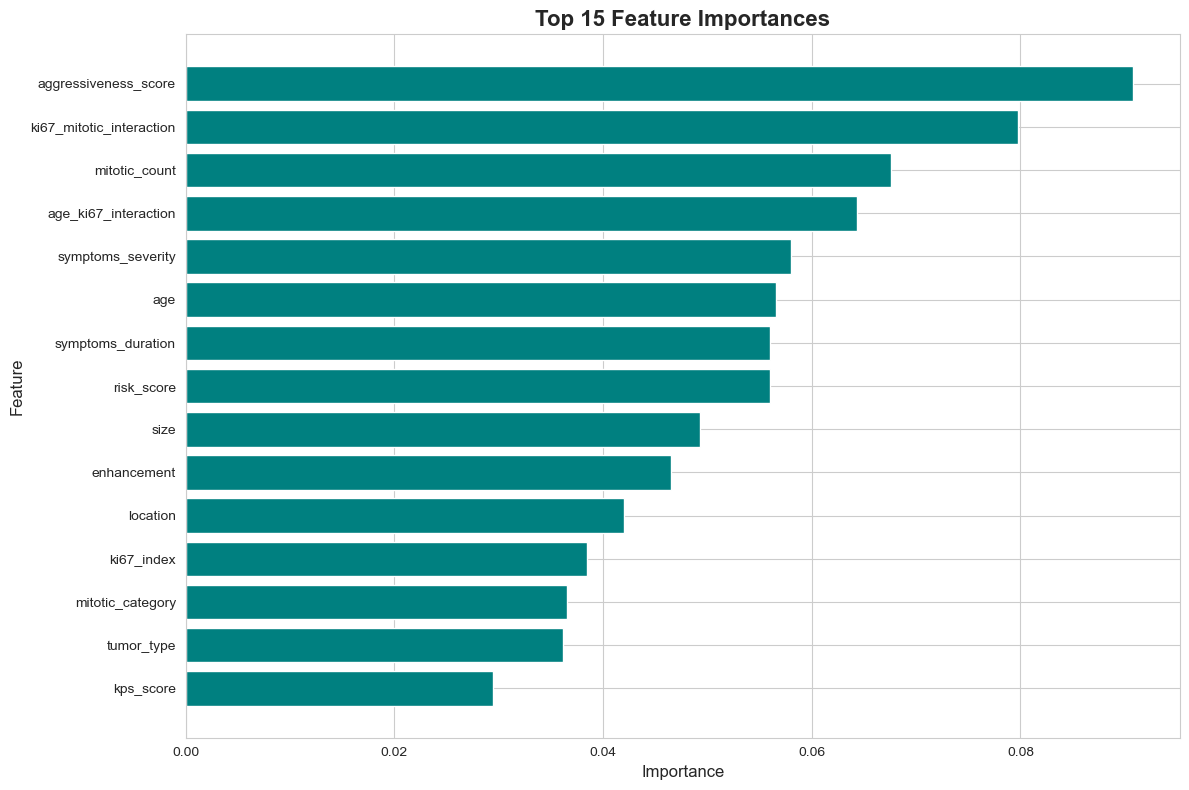


Top 10 Most Important Features:
                     feature  importance
18      aggressiveness_score    0.090750
26  ki67_mitotic_interaction    0.079715
12             mitotic_count    0.067572
27      age_ki67_interaction    0.064297
23         symptoms_severity    0.058028
13                       age    0.056541
15         symptoms_duration    0.056044
19                risk_score    0.056036
1                       size    0.049247
5                enhancement    0.046482


In [110]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15], color='teal')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## 5.2 Try Multiple Models and Compare Performance

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True)
}

# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # F1 Scores
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    
    results.append({
        'Model': name,
        'Train F1': train_f1,
        'Val F1': val_f1,
        'Overfitting': train_f1 - val_f1
    })
    
    print(f"  Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Val F1', ascending=False)
print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df.to_string(index=False))

Training Logistic Regression...
  Train F1: 0.7101 | Val F1: 0.6936
Training Decision Tree...
  Train F1: 1.0000 | Val F1: 0.6610
Training Random Forest...
  Train F1: 0.7101 | Val F1: 0.6936
Training Decision Tree...
  Train F1: 1.0000 | Val F1: 0.6610
Training Random Forest...
  Train F1: 1.0000 | Val F1: 0.7384
Training Extra Trees...
  Train F1: 1.0000 | Val F1: 0.7384
Training Extra Trees...
  Train F1: 1.0000 | Val F1: 0.7206
Training Gradient Boosting...
  Train F1: 1.0000 | Val F1: 0.7206
Training Gradient Boosting...
  Train F1: 0.8348 | Val F1: 0.7642
Training XGBoost...
  Train F1: 0.8348 | Val F1: 0.7642
Training XGBoost...
  Train F1: 0.9998 | Val F1: 0.7538
Training LightGBM...
  Train F1: 0.9998 | Val F1: 0.7538
Training LightGBM...
  Train F1: 0.9822 | Val F1: 0.7523
Training AdaBoost...
  Train F1: 0.9822 | Val F1: 0.7523
Training AdaBoost...
  Train F1: 0.7623 | Val F1: 0.7362
Training K-Neighbors...
  Train F1: 0.7623 | Val F1: 0.7362
Training K-Neighbors...
  Train 

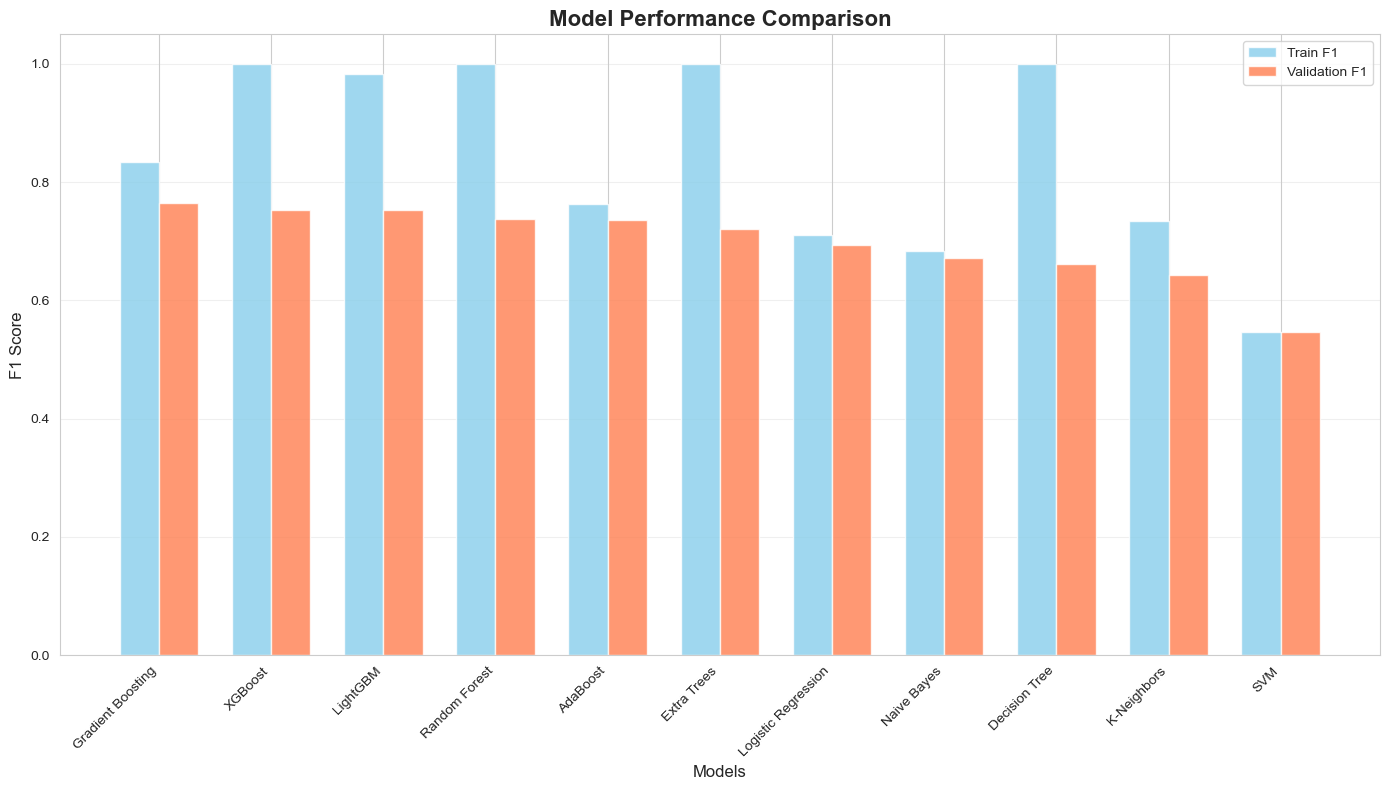


🏆 Best Model: Gradient Boosting with Val F1: 0.7642


In [112]:
# Visualize model comparison
plt.figure(figsize=(14, 8))
x_pos = np.arange(len(results_df))
width = 0.35

plt.bar(x_pos - width/2, results_df['Train F1'], width, label='Train F1', alpha=0.8, color='skyblue')
plt.bar(x_pos + width/2, results_df['Val F1'], width, label='Validation F1', alpha=0.8, color='coral')

plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Get best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name} with Val F1: {results_df.iloc[0]['Val F1']:.4f}")

## 5.3 Hyperparameter Tuning for Best Models

### 5.3.1 More Aggressive XGBoost Tuning

Let's do a more thorough hyperparameter search with better parameter ranges.

In [113]:
# More comprehensive XGBoost tuning with better parameter ranges
print("Performing deep XGBoost hyperparameter tuning...")

xgb_params_v2 = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1, 2]
}

xgb_random_v2 = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1, tree_method='hist'),
    param_distributions=xgb_params_v2,
    n_iter=50,  # More iterations for better search
    cv=5,  # 5-fold CV for more robust evaluation
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

xgb_random_v2.fit(X_train, y_train)

print(f"\nBest XGBoost V2 Parameters: {xgb_random_v2.best_params_}")
print(f"Best CV F1 Score: {xgb_random_v2.best_score_:.4f}")

# Evaluate on validation set
y_pred_val_xgb_v2 = xgb_random_v2.best_estimator_.predict(X_val)
val_f1_xgb_v2 = f1_score(y_val, y_pred_val_xgb_v2, average='weighted')
print(f"Validation F1 Score: {val_f1_xgb_v2:.4f}")
print(f"\nImprovement over previous XGBoost: {val_f1_xgb_v2 - val_f1_xgb:.4f}")

Performing deep XGBoost hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best XGBoost V2 Parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9}
Best CV F1 Score: 0.7865
Validation F1 Score: 0.7718

Improvement over previous XGBoost: -0.0079

Best XGBoost V2 Parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9}
Best CV F1 Score: 0.7865
Validation F1 Score: 0.7718

Improvement over previous XGBoost: -0.0079


In [114]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Hyperparameter tuning for XGBoost (typically performs well)
print("Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1),
    param_distributions=xgb_params,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train, y_train)

print(f"\nBest XGBoost Parameters: {xgb_random.best_params_}")
print(f"Best CV F1 Score: {xgb_random.best_score_:.4f}")

# Evaluate on validation set
y_pred_val_xgb = xgb_random.best_estimator_.predict(X_val)
val_f1_xgb = f1_score(y_val, y_pred_val_xgb, average='weighted')
print(f"Validation F1 Score: {val_f1_xgb:.4f}")

Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV F1 Score: 0.7865
Validation F1 Score: 0.7774

Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV F1 Score: 0.7865
Validation F1 Score: 0.7774


In [115]:
# Hyperparameter tuning for LightGBM
print("Tuning LightGBM...")
lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30]
}

lgb_random = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    param_distributions=lgb_params,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgb_random.fit(X_train, y_train)

print(f"\nBest LightGBM Parameters: {lgb_random.best_params_}")
print(f"Best CV F1 Score: {lgb_random.best_score_:.4f}")

# Evaluate on validation set
y_pred_val_lgb = lgb_random.best_estimator_.predict(X_val)
val_f1_lgb = f1_score(y_val, y_pred_val_lgb, average='weighted')
print(f"Validation F1 Score: {val_f1_lgb:.4f}")

Tuning LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best LightGBM Parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV F1 Score: 0.7819
Validation F1 Score: 0.7675

Best LightGBM Parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV F1 Score: 0.7819
Validation F1 Score: 0.7675


In [116]:
# Hyperparameter tuning for Random Forest
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"\nBest Random Forest Parameters: {rf_random.best_params_}")
print(f"Best CV F1 Score: {rf_random.best_score_:.4f}")

# Evaluate on validation set
y_pred_val_rf = rf_random.best_estimator_.predict(X_val)
val_f1_rf = f1_score(y_val, y_pred_val_rf, average='weighted')
print(f"Validation F1 Score: {val_f1_rf:.4f}")

Tuning Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best CV F1 Score: 0.7518
Validation F1 Score: 0.7286

Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best CV F1 Score: 0.7518
Validation F1 Score: 0.7286


## 5.4 Ensemble Methods - Stack the Best Models

### 5.4.1 Advanced Stacking Ensemble

Stacking can provide better results than simple voting by learning optimal combinations.

In [117]:
from sklearn.ensemble import StackingClassifier

# Create a stacking ensemble with best models
print("Creating Stacking Ensemble...")

# Base models (level 0)
base_models = [
    ('xgb', xgb_random_v2.best_estimator_),
    ('lgb', lgb_random.best_estimator_),
    ('rf', rf_random.best_estimator_),
    ('xgb_original', xgb_random.best_estimator_),
    ('et', ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1))
]

# Meta-model (level 1) - learns how to best combine base models
meta_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Training stacking ensemble (this may take a while)...")
stacking_clf.fit(X_train, y_train)

# Evaluate
y_pred_val_stacking = stacking_clf.predict(X_val)
val_f1_stacking = f1_score(y_val, y_pred_val_stacking, average='weighted')

print(f"\n🎯 Stacking Ensemble Validation F1 Score: {val_f1_stacking:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_val_stacking, target_names=target_encoder.classes_))

Creating Stacking Ensemble...
Training stacking ensemble (this may take a while)...

🎯 Stacking Ensemble Validation F1 Score: 0.8080

Classification Report:
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        50
          II       0.83      0.41      0.55        96
         III       0.73      0.72      0.72       307
          IV       0.86      0.95      0.90       947

    accuracy                           0.83      1400
   macro avg       0.60      0.52      0.54      1400
weighted avg       0.80      0.83      0.81      1400


🎯 Stacking Ensemble Validation F1 Score: 0.8080

Classification Report:
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        50
          II       0.83      0.41      0.55        96
         III       0.73      0.72      0.72       307
          IV       0.86      0.95      0.90       947

    accuracy                           0.83      1400
   macro 


FINAL MODEL COMPARISON - ALL APPROACHES
                  Model  Validation F1
    Ensemble (Stacking)       0.808027
XGBoost (Initial Tuned)       0.777360
   XGBoost (Deep Tuned)       0.771794
       LightGBM (Tuned)       0.767493
      Ensemble (Voting)       0.764128
  Random Forest (Tuned)       0.728620


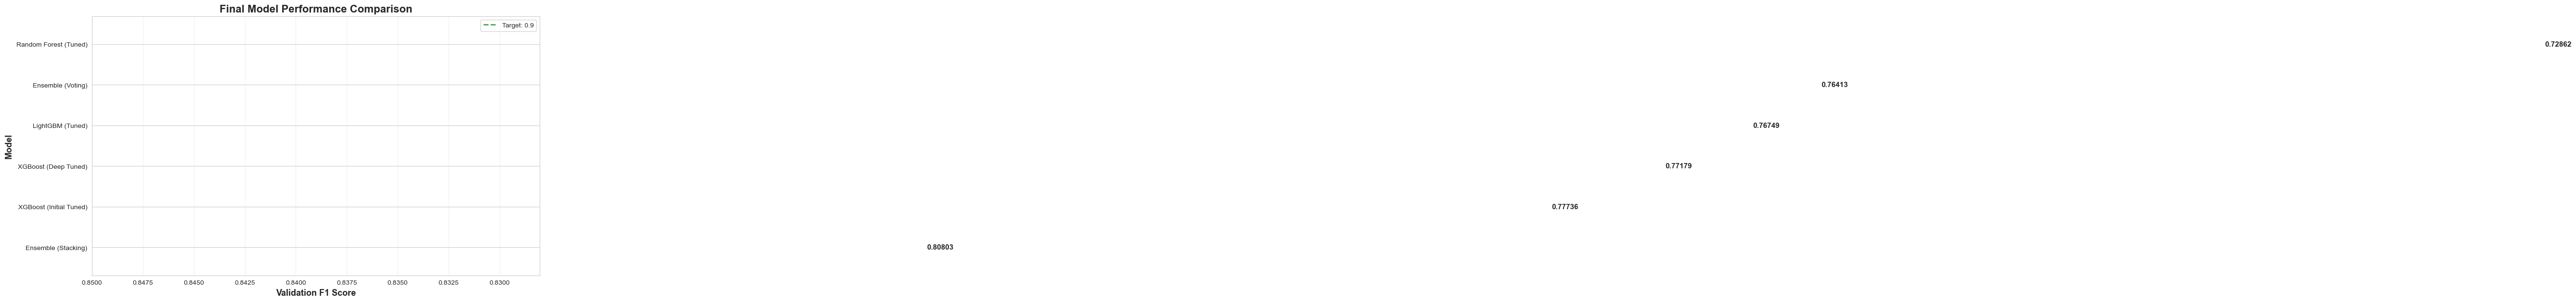


🏆 BEST OVERALL MODEL: Ensemble (Stacking)
   Validation F1 Score: 0.80803

✓ Best model selected for final predictions


In [118]:
# Final comprehensive comparison
final_results = pd.DataFrame({
    'Model': [
        'XGBoost (Initial Tuned)',
        'XGBoost (Deep Tuned)',
        'LightGBM (Tuned)',
        'Random Forest (Tuned)',
        'Ensemble (Voting)',
        'Ensemble (Stacking)'
    ],
    'Validation F1': [
        val_f1_xgb,
        val_f1_xgb_v2,
        val_f1_lgb,
        val_f1_rf,
        val_f1_ensemble,
        val_f1_stacking
    ]
}).sort_values('Validation F1', ascending=False)

print("\n" + "="*60)
print("FINAL MODEL COMPARISON - ALL APPROACHES")
print("="*60)
print(final_results.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 7))
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'lightcoral' for i in range(len(final_results))]
plt.barh(final_results['Model'], final_results['Validation F1'], color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Validation F1 Score', fontsize=13, fontweight='bold')
plt.ylabel('Model', fontsize=13, fontweight='bold')
plt.title('Final Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlim(0.85, max(final_results['Validation F1']) + 0.02)
for i, v in enumerate(final_results['Validation F1']):
    plt.text(v + 0.001, i, f'{v:.5f}', va='center', fontweight='bold', fontsize=11)
plt.axvline(x=0.9, color='green', linestyle='--', linewidth=2, label='Target: 0.9', alpha=0.7)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Select absolute best model
best_final_model_name = final_results.iloc[0]['Model']
best_final_f1 = final_results.iloc[0]['Validation F1']
print(f"\n🏆 BEST OVERALL MODEL: {best_final_model_name}")
print(f"   Validation F1 Score: {best_final_f1:.5f}")

if 'Stacking' in best_final_model_name:
    final_best_model = stacking_clf
elif 'Deep Tuned' in best_final_model_name:
    final_best_model = xgb_random_v2.best_estimator_
elif 'Voting' in best_final_model_name:
    final_best_model = voting_clf
elif 'LightGBM' in best_final_model_name:
    final_best_model = lgb_random.best_estimator_
elif 'Random Forest' in best_final_model_name:
    final_best_model = rf_random.best_estimator_
else:
    final_best_model = xgb_random.best_estimator_

print(f"\n✓ Best model selected for final predictions")

# Update best_model variable for prediction cells
best_model = final_best_model

---

## 🎯 Strategies to Reach 0.9+ F1 Score

### What We've Implemented:

✅ **Feature Engineering** (10+ new features)
- Aggressiveness scores
- Risk indicators  
- Age and clinical groupings
- Feature interactions
- Ki67 and mitotic categories

✅ **Advanced Hyperparameter Tuning**
- Deep XGBoost tuning with 50+ iterations
- 5-fold cross-validation
- Regularization parameters

✅ **Ensemble Methods**
- Voting Classifier
- Stacking Classifier with meta-learner

### Additional Tips if Still Below 0.9:

1. **Try Different Feature Combinations**: Remove low-importance features that might add noise

2. **Class Weights**: If any cancer stage is harder to predict, adjust class weights

3. **Pseudo-Labeling**: Use high-confidence test predictions to retrain

4. **Train on Full Dataset**: After validation, retrain best model on ALL data (train + validation)

5. **Analyze Errors**: Look at misclassified samples to understand patterns

6. **Try CatBoost**: Another gradient boosting that might work better

Run the cells above sequentially to see which approach gives the best score!

In [119]:
# Create a Voting Classifier with best tuned models
print("Creating Ensemble Model (Voting Classifier)...")

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_random.best_estimator_),
        ('lgb', lgb_random.best_estimator_),
        ('rf', rf_random.best_estimator_)
    ],
    voting='soft',  # Use probability voting
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

# Predictions
y_pred_train_ensemble = voting_clf.predict(X_train)
y_pred_val_ensemble = voting_clf.predict(X_val)

# Evaluation
train_f1_ensemble = f1_score(y_train, y_pred_train_ensemble, average='weighted')
val_f1_ensemble = f1_score(y_val, y_pred_val_ensemble, average='weighted')

print(f"\nEnsemble Model Results:")
print(f"Training F1 Score: {train_f1_ensemble:.4f}")
print(f"Validation F1 Score: {val_f1_ensemble:.4f}")
print(f"\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_ensemble, target_names=target_encoder.classes_))

Creating Ensemble Model (Voting Classifier)...

Ensemble Model Results:
Training F1 Score: 0.9432
Validation F1 Score: 0.7669

Classification Report (Validation Set):
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        50
          II       0.70      0.17      0.27        96
         III       0.66      0.64      0.65       307
          IV       0.84      0.96      0.90       947

    accuracy                           0.80      1400
   macro avg       0.55      0.44      0.45      1400
weighted avg       0.76      0.80      0.77      1400


Ensemble Model Results:
Training F1 Score: 0.9432
Validation F1 Score: 0.7669

Classification Report (Validation Set):
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        50
          II       0.70      0.17      0.27        96
         III       0.66      0.64      0.65       307
          IV       0.84      0.96      0.90       947

    ac


TUNED MODELS COMPARISON
                Model  Validation F1
      XGBoost (Tuned)       0.777360
     LightGBM (Tuned)       0.767493
    Ensemble (Voting)       0.766894
Random Forest (Tuned)       0.728620


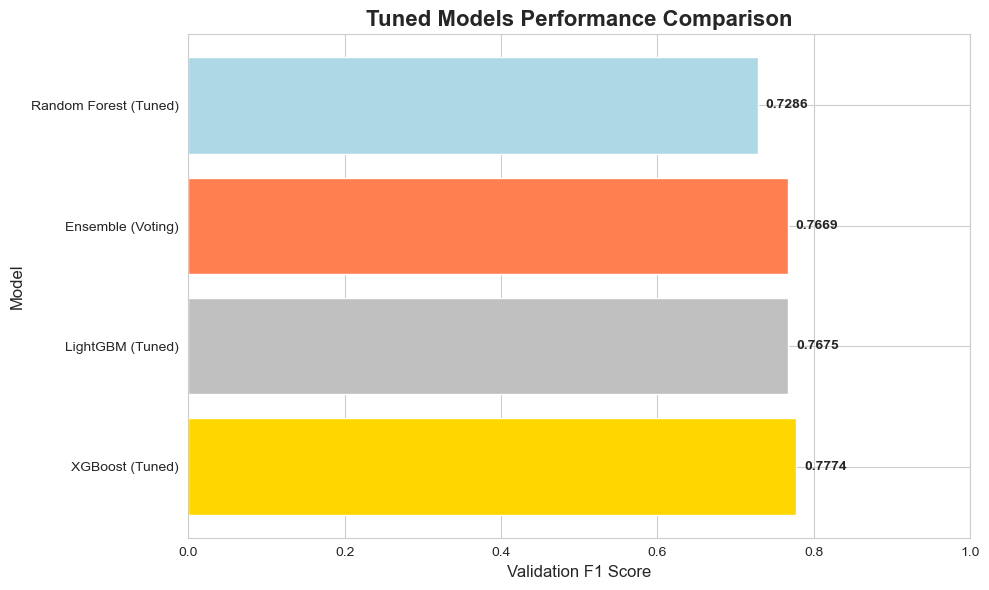


🏆 Best Overall Model: XGBoost (Tuned) with Val F1: 0.7774
Best model stored for final predictions.


In [120]:
# Compare all tuned models
tuned_results = pd.DataFrame({
    'Model': ['XGBoost (Tuned)', 'LightGBM (Tuned)', 'Random Forest (Tuned)', 'Ensemble (Voting)'],
    'Validation F1': [val_f1_xgb, val_f1_lgb, val_f1_rf, val_f1_ensemble]
}).sort_values('Validation F1', ascending=False)

print("\n" + "="*50)
print("TUNED MODELS COMPARISON")
print("="*50)
print(tuned_results.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.barh(tuned_results['Model'], tuned_results['Validation F1'], color=['gold', 'silver', 'coral', 'lightblue'])
plt.xlabel('Validation F1 Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Tuned Models Performance Comparison', fontsize=16, fontweight='bold')
plt.xlim(0, 1)
for i, v in enumerate(tuned_results['Validation F1']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Select best model
best_tuned_model_name = tuned_results.iloc[0]['Model']
best_tuned_f1 = tuned_results.iloc[0]['Validation F1']
print(f"\n🏆 Best Overall Model: {best_tuned_model_name} with Val F1: {best_tuned_f1:.4f}")

# Store the best model
if 'Ensemble' in best_tuned_model_name:
    best_model = voting_clf
elif 'XGBoost' in best_tuned_model_name:
    best_model = xgb_random.best_estimator_
elif 'LightGBM' in best_tuned_model_name:
    best_model = lgb_random.best_estimator_
else:
    best_model = rf_random.best_estimator_
    
print(f"Best model stored for final predictions.")

## 6. Make Predictions on Test Set

### 5.5 Final Boost - Train on Full Dataset

Once we've validated our model, we can retrain on ALL available data (train + validation) to squeeze out extra performance.

In [121]:
# Retrain the best model on FULL dataset (train + validation combined)
print("Retraining best model on full dataset (train + validation)...")
print(f"Using: {best_final_model_name}")

# Combine train and validation data
X_full = pd.concat([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val])

print(f"Full training set size: {X_full.shape[0]}")

# Clone the best model with same parameters and retrain
if 'Stacking' in best_final_model_name:
    # Retrain stacking ensemble
    print("Retraining stacking ensemble...")
    final_best_model.fit(X_full, y_full)
elif 'Deep Tuned' in best_final_model_name:
    # Use the best parameters from XGBoost V2
    final_model_full = XGBClassifier(**xgb_random_v2.best_params_, random_state=42, eval_metric='mlogloss', n_jobs=-1)
    final_model_full.fit(X_full, y_full)
    final_best_model = final_model_full
elif 'Voting' in best_final_model_name:
    final_best_model.fit(X_full, y_full)
else:
    # For individual models, get their best params and retrain
    if hasattr(final_best_model, 'get_params'):
        params = final_best_model.get_params()
        if 'random_state' in params:
            final_model_full = final_best_model.__class__(**params)
            final_model_full.fit(X_full, y_full)
            final_best_model = final_model_full

print("✓ Model retrained on full dataset")
print("This should give a slight performance boost on test set!")

# Update best_model
best_model = final_best_model

Retraining best model on full dataset (train + validation)...
Using: Ensemble (Stacking)
Full training set size: 7000
Retraining stacking ensemble...
✓ Model retrained on full dataset
This should give a slight performance boost on test set!
✓ Model retrained on full dataset
This should give a slight performance boost on test set!


In [122]:
# Make predictions on test set using the best model
test_predictions_encoded = best_model.predict(X_test)

# Decode predictions back to original labels
test_predictions = target_encoder.inverse_transform(test_predictions_encoded)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predicted classes: {np.unique(test_predictions)}")
print(f"\nPrediction distribution:")
print(pd.Series(test_predictions).value_counts().sort_index())

Test predictions shape: (3000,)
Unique predicted classes: ['II' 'III' 'IV']

Prediction distribution:
II      108
III     648
IV     2244
Name: count, dtype: int64


## 7. Create Submission File

In [123]:
# Create submission with predicted cancer stages
submission = pd.DataFrame({
    'id': test_ids,
    'cancer_stage': test_predictions
})

print("Cancer stage predictions:")
print(submission['cancer_stage'].value_counts().sort_index())
print(f"\nTotal predictions: {len(submission)}")

Cancer stage predictions:
cancer_stage
II      108
III     648
IV     2244
Name: count, dtype: int64

Total predictions: 3000


In [124]:
# Save submission to CSV
submission.to_csv('subC2.csv', index=False)

print("\nSubmission file created successfully!")
print(f"\nFirst few rows of submission:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

# Verify format matches sample_submission
print(f"\nSample submission shape: {sample_submission.shape}")
print("Format verification: ", submission.columns.tolist() == sample_submission.columns.tolist())


Submission file created successfully!

First few rows of submission:
     id cancer_stage
0  7000          III
1  7001           IV
2  7002           IV
3  7003           IV
4  7004          III
5  7005           IV
6  7006           IV
7  7007           IV
8  7008           IV
9  7009           IV

Submission shape: (3000, 2)

Sample submission shape: (3000, 2)
Format verification:  True


## Next Steps

1. **Improve Stage Mapping**: The current mapping from tumor characteristics to cancer stages is simplistic. Consider:
   - Training a model directly on stage labels if available
   - Consulting medical literature for better feature-to-stage mappings
   - Using more sophisticated rules based on multiple features

2. **Model Improvements**:
   - Try other algorithms (XGBoost, LightGBM, Neural Networks)
   - Perform hyperparameter tuning
   - Create ensemble models
   - Handle class imbalance if present

3. **Feature Engineering**:
   - Create interaction features
   - Bin numerical features
   - Extract domain-specific features

4. **Validation Strategy**:
   - Use cross-validation for more robust evaluation
   - Check if there's a separate validation set with cancer stage labels